# Imports

In [1]:
import json 
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Functions

### 1. Data cleaning

In [5]:
# def remove_special_characters(text):
#     # remove_special = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     # # clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
#     # remove_special = re.sub(r'[0-9]', '', text)

#     text = re.sub('\[.*\]','', text)
#     text = re.sub('\S*\d\S*\s*','', text)
#     return text

# def text_replace(text):
#     modified_text = text.replace('xx', '').replace('-PRON-', '').strip()
#     return modified_text.strip()


# def remove_punctuation(text):
#     translator = str.maketrans('', '', string.punctuation)
#     no_punctuation = text.translate(translator)

#     return no_punctuation

# def convert_to_lowercase(text):
#     text_lower = text.lower()

#     return text_lower

# def remove_stopwords(tokens):
#     token_fil = [word for word in tokens if word.lower() not in stop_words]

#     return token_fil

# def tokenize_text(text):
#     tokens = nltk.word_tokenize(text)

#     return tokens
    
    


In [10]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\[.*\]','', text)
    clean_text = re.sub('\S*\d\S*\s*','', text)

    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def token_text(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    
    return ' '.join(filtered_words)

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '').replace('+', ' ')

    return replaced

# def clean_cat(text):
#     replaced = text.replace('+', ' ').replace('-', ' ').lower()
#     punctuation = replaced.translate(str.maketrans('', '', string.punctuation))

#     return punctuation

### 2. Merge cleaning functions to one function

In [11]:
def preprocess_text(text):
    # Apply preprocessing functions in a specific order
    
    text = convert_to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    text = replace(text)
    text = token_text(text)
    text = remove_stopwords(text)

    # return ' '.join(text)
    return text


In [12]:
# # nltk download - issue with ssl certyficate

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('all')

### 3. Restore basic forms of words

In [13]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    token_lemma = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in STOP_WORDS]

    return ' '.join(token_lemma)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)
    

# finding ngrams

In [14]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [15]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [16]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)

df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

# df[df['category']==''] = np.nan
# df = df[~df['category'].isnull()]

# text cleaning

In [17]:

data = df # replace to have possibility to load back original data
data['complaint_text'] = data['complaint_text'].astype(str)
data['text_clean'] = data['complaint_text'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))

# data['category'] = data['category'].astype(str)
# data['cat_clean'] = data['category'].apply(lambda x: clean_cat(x))

### Check data

(array([9.541e+03, 6.318e+03, 2.623e+03, 1.245e+03, 6.800e+02, 2.560e+02,
        1.300e+02, 7.800e+01, 4.800e+01, 4.000e+01, 2.800e+01, 1.700e+01,
        1.000e+01, 1.000e+01, 7.000e+00, 9.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 8.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([    0. ,   231.9,   463.8,   695.7,   927.6,  1159.5,  1391.4,
         1623.3,  1855.2,  2087.1,  2319. ,  2550.9,  2782.8,  3014.7,
         3246.6,  3478.5,  3710.4,  3942.3,  4174.2,  4406.1,  4638. ,
         4869.9,  5101.8,  5333.7,  5565.6,  5797.5,  6029.4,  6261.3,
         6493.2,  6725.1,  6957. ,  7188.9,  7420.8,  7652.7,  7884.6,
         8116.5,  834

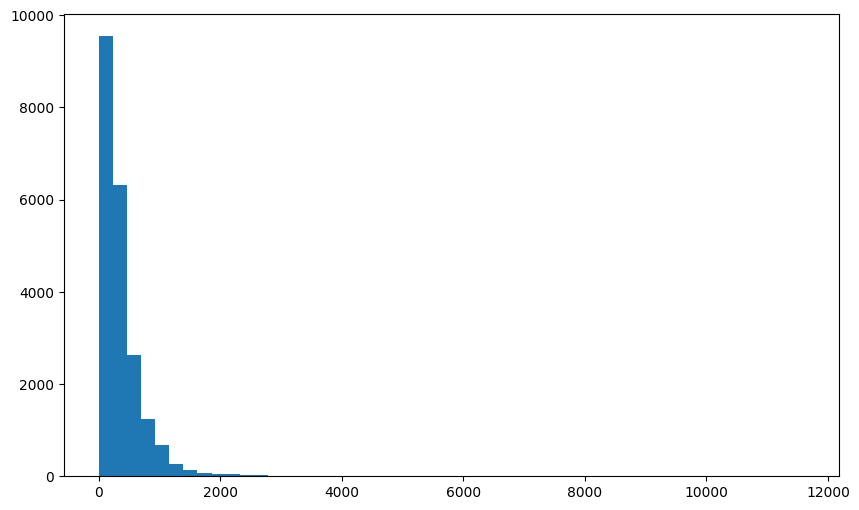

In [18]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data['text_clean']]
doc_lens = [len(d) for d in data['text_clean']]
plt.hist(doc_lens, bins = 50)

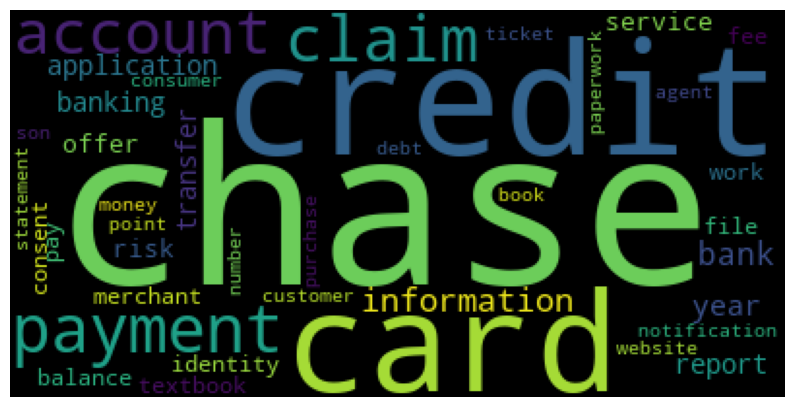

In [19]:

from wordcloud import WordCloud

# wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))
wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

### Finding top n-grams

In [47]:
top_unigrams = get_top_ngrams(data['text_clean'], 1)
top_bigrams = get_top_ngrams(data['text_clean'], 2)
top_trigrams = get_top_ngrams(data['text_clean'], 3)


print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('chase',), 58214), (('account',), 44630), (('credit',), 32848), (('card',), 30230), (('payment',), 21162)]

 top top_bigrams : 
 [(('credit', 'card'), 12854), (('credit', 'report'), 3890), (('chase', 'credit'), 3621), (('account', 'chase'), 3297), (('customer', 'service'), 2976)]

 top top_trigrams : 
 [(('chase', 'credit', 'card'), 2525), (('credit', 'card', 'account'), 1155), (('credit', 'card', 'company'), 993), (('credit', 'card', 'chase'), 962), (('inquiry', 'credit', 'report'), 535)]


### Vectorizer

In [48]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = tfidf.fit_transform(data['text_clean']) # document term metrix
dtm = tfidf.fit_transform(data['text_clean'])
feature_names = np.array(tfidf.get_feature_names_out())

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
# model = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

### NFM

In [49]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, init='random', random_state=40)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")



Top 15 words for Topic 0:

['account', 'bank', 'chase', 'money', 'balance', 'fund', 'fee', 'branch', 'transfer', 'number', 'reason', 'checking', 'deposit', 'information', 'business']


Top 15 words for Topic 1:

['credit', 'card', 'report', 'inquiry', 'score', 'chase', 'company', 'limit', 'application', 'debt', 'bureau', 'balance', 'reporting', 'information', 'year']


Top 15 words for Topic 2:

['payment', 'loan', 'mortgage', 'chase', 'month', 'modification', 'time', 'home', 'year', 'balance', 'rate', 'statement', 'property', 'pay', 'date']


Top 15 words for Topic 3:

['charge', 'chase', 'card', 'dispute', 'transaction', 'claim', 'fraud', 'merchant', 'fee', 'purchase', 'service', 'time', 'email', 'phone', 'customer']


Top 15 words for Topic 4:

['check', 'money', 'bank', 'fund', 'deposit', 'day', 'branch', 'chase', 'cash', 'claim', 'business', 'person', 'time', 'customer', 'hold']




In [50]:
data.topic.value_counts()

topic
3    5443
2    5041
1    4265
0    3347
4    2976
Name: count, dtype: int64

In [24]:
# temp =data[['complaint_text','text_clean','category', 'cat_clean', 'topic']].groupby('topic').head(30)
# temp.sort_values('topic')

# data[data['topic'] == 'Other'].head(30)


In [25]:


#Create the dictionary of Topic names and Topics
# topic_mapping = {
#     0: 'Fees, Charges, and Account Balances',
#     1: 'Credit Cards, Credit Reports',
#     2: 'Other',
#     3: 'Banking and Account activities',
#     4: 'Payments, Loans, and Mortgages'
# }

topic_mapping = {
    0: 'Other',
    1: 'Payments, Loans, and Mortgages',
    2: 'Fees, Charges, and Account Balances',
    3: 'Banking and Account activities',
    4: 'Credit Cards, Credit Reports'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

data.to_csv('data.csv', index=False) # saving dataset

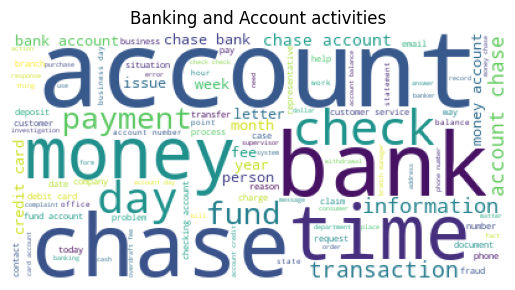

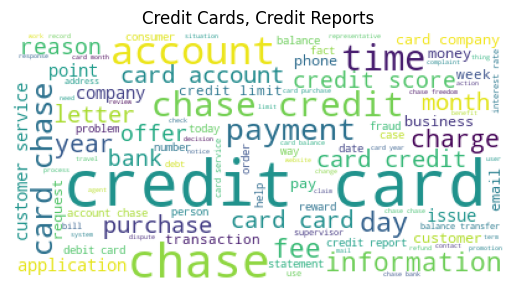

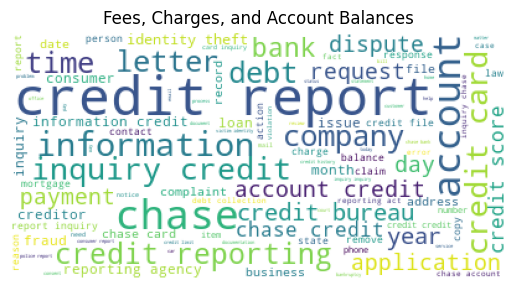

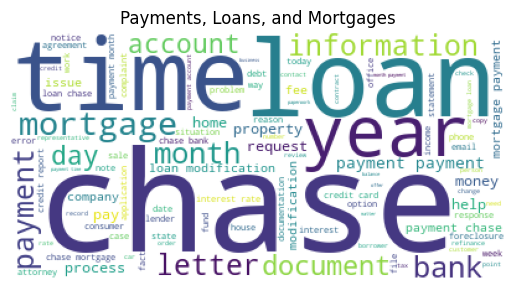

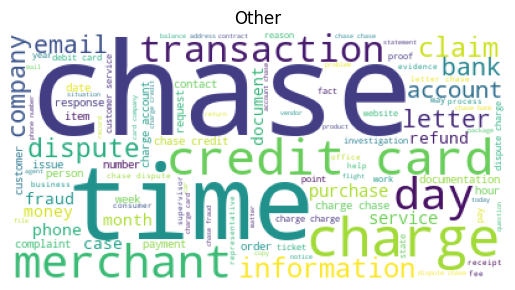

In [26]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	# wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

In [27]:
data.topic.value_counts()

topic
Banking and Account activities         7347
Payments, Loans, and Mortgages         4532
Credit Cards, Credit Reports           3741
Other                                  3366
Fees, Charges, and Account Balances    2086
Name: count, dtype: int64

# importing dataset

In [29]:
data = pd.read_csv('data.csv')

# TESTING ON DIFFERENT CLASSIFICATORS

In [30]:
training_data = data[['complaint_text','topic']]

In [43]:
# training_data['text_clean'] = training_data['text_clean'].fillna('')
# training_data[training_data['text_clean']==''] = np.nan
# training_data = training_data[~training_data['text_clean'].isnull()]

In [31]:
X = training_data['complaint_text']
y = training_data['topic']

In [32]:
cv = CountVectorizer()
X_vec = cv.fit_transform(X)

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)

In [34]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=40, stratify=y)

In [35]:
def display_classification_report(model):
    
    # Calculate ROC AUC scores
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba, average='weighted', multi_class='ovr'), 2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr'), 2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)

    # Calculate precision, recall, fscore, and support
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
    precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    # Calculate and print accuracy scores
    acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
    acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)
    
    
    print('Train Accuracy :', acc_score_train)
    print('Test Accuracy :', acc_score_test)
        
    # Print classification reports
    model_report_train = classification_report(y_train, y_train_pred)
    model_report_test = classification_report(y_test, y_test_pred)
    
    print('Classification Report for Train:\n', model_report_train)
    print('Classification Report for Test:\n', model_report_test)

    # # Plot the confusion matrix
    # fig, ax = plt.subplots(figsize=(12, 8))
    # # Create the confusion matrix
    # cm = confusion_matrix(y_test, y_test_pred)
    # cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    # cmp.plot(ax=ax)
    # plt.xticks(rotation=80)

    # plt.show();

    # metric.append(roc_auc_score_train)
    # metric.append(roc_auc_score_test)
    # metric.append(acc_score_train)
    # metric.append(acc_score_test)
    # metric.append(round(precision_train, 2))
    # metric.append(round(precision_test, 2))
    # metric.append(round(recall_train, 2))
    # metric.append(round(recall_test, 2))
    # metric.append(round(fscore_train, 2))
    # metric.append(round(fscore_test, 2))


In [36]:
# scaller for log reg

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
# metric2=[]
display_classification_report(log_reg)

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.99
Train Accuracy : 0.95
Test Accuracy : 0.91
Classification Report for Train:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.95      0.98      0.96      5143
       Credit Cards, Credit Reports       0.96      0.95      0.96      2619
Fees, Charges, and Account Balances       0.97      0.88      0.93      1460
                              Other       0.96      0.90      0.93      2356
     Payments, Loans, and Mortgages       0.94      0.98      0.96      3172

                           accuracy                           0.95     14750
                          macro avg       0.96      0.94      0.95     14750
                       weighted avg       0.95      0.95      0.95     14750

Classification Report for Test:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.92      0.96      0.94

In [115]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# FINAL TEST

In [44]:
input = 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [45]:
test = cv.transform([input])
test_tfidf = tfidf_t.transform(test)

In [46]:
prediction=log_reg.predict(test_tfidf)
prediction

array(['Credit Cards, Credit Reports'], dtype=object)